In [1]:
import os
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, interpolate
from scipy.interpolate import CubicSpline
import numpy as np
import plotly.graph_objects as go
import pickle
import re
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy.signal import welch, hilbert
from scipy.stats import skew, kurtosis, entropy
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

participant_id = 1 # Sofia data


In [3]:
def plot_single(all_data, n_samples=5000):
    """Plot single signal with seaborn styling."""
    # Apply seaborn-style settings
    plt.style.use('seaborn')

    col1_name = all_data.columns[0]
    col2_name = all_data.columns[1]

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    axes[0].plot(all_data[col1_name].iloc[:n_samples],
                label=f'{col1_name}',
                linewidth=2,
                alpha=0.8)
    axes[0].set_title(f'Signal: {col1_name}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Samples', fontsize=12)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].legend(frameon=True, fancybox=True, shadow=True)
    axes[0].grid(True, linestyle='-', alpha=0.2, color='gray')

    axes[1].plot(all_data[col2_name].iloc[:n_samples],
                label=f'{col2_name}',
                linewidth=2,
                alpha=0.8)
    axes[1].set_title(f'Signal: {col2_name}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Samples', fontsize=12)
    axes[1].set_ylabel('Amplitude', fontsize=12)
    axes[1].legend(frameon=True, fancybox=True, shadow=True)
    axes[1].grid(True, linestyle='-', alpha=0.2, color='gray')

    plt.tight_layout()
    plt.show()
    return fig

def plot_signals(all_data, vertical_raw_col='vertical_value', vertical_filtered_col='vertical_filtered', vertical_smoothed_col=None,
                 horizontal_raw_col='horizontal_value', horizontal_filtered_col='horizontal_filtered', horizontal_smoothed_col=None, n_samples=5000):
    """Plot signals with seaborn styling."""
    # Apply seaborn-style settings
    plt.style.use('seaborn')

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    axes[0].plot(all_data[vertical_raw_col].iloc[:n_samples],
                label='Original Vertical',
                linewidth=2,
                alpha=0.7)
    axes[0].plot(all_data[vertical_filtered_col].iloc[:n_samples],
                label='Filtered Vertical',
                linewidth=2.5,
                alpha=0.9)

    if vertical_smoothed_col is not None:
        axes[0].plot(all_data[vertical_smoothed_col].iloc[:n_samples],
                    label='Smoothed Vertical',
                    linewidth=2.5,
                    alpha=0.9)

    axes[0].set_title('Vertical Signal: Original vs Filtered', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Samples', fontsize=12)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].legend(frameon=True, fancybox=True, shadow=True)
    axes[0].grid(True, linestyle='-', alpha=0.2, color='gray')

    axes[1].plot(all_data[horizontal_raw_col].iloc[:n_samples],
                label='Original Horizontal',
                linewidth=2,
                alpha=0.7)
    axes[1].plot(all_data[horizontal_filtered_col].iloc[:n_samples],
                label='Filtered Horizontal',
                linewidth=2.5,
                alpha=0.9)

    if horizontal_smoothed_col is not None:
        axes[1].plot(all_data[horizontal_smoothed_col].iloc[:n_samples],
                    label='Smoothed Horizontal',
                    linewidth=2.5,
                    alpha=0.9)

    axes[1].set_title('Horizontal Signal: Original vs Filtered', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Samples', fontsize=12)
    axes[1].set_ylabel('Amplitude', fontsize=12)
    axes[1].legend(frameon=True, fancybox=True, shadow=True)
    axes[1].grid(True, linestyle='-', alpha=0.2, color='gray')

    plt.tight_layout()
    plt.show()
    return fig

def plot_filter_response(sos, worN=1500, filter_type=None, cutoff_freq=None, bw=None, fs=2.0):
    """Plot filter response with seaborn styling."""
    # Apply seaborn-style settings
    plt.style.use('seaborn')

    w, h = signal.sosfreqz(sos, worN=worN)
    w_normalized = w / np.pi
    freq = w_normalized * (fs/2)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    db = 20 * np.log10(np.maximum(np.abs(h), 1e-10))
    min_db = np.floor(np.min(db) / 10) * 10
    max_db = np.ceil(np.max(db) / 10) * 10

    if max_db - min_db < 40:
        min_db = max_db - 40

    ax1.plot(freq, db, linewidth=2.5, alpha=0.9)
    ax1.set_ylim([min_db, max_db + 5])

    db_range = max_db - min_db
    if db_range <= 60:
        step = 10
    elif db_range <= 120:
        step = 20
    else:
        step = 40
    db_ticks = np.arange(min_db, max_db + step, step)
    ax1.set_yticks(db_ticks)

    if filter_type and cutoff_freq is not None:
        if filter_type.lower() in ['lowpass', 'highpass']:
            cutoff = cutoff_freq
            ax1.axvline(x=cutoff, color='red', linestyle='--', linewidth=2, alpha=0.8,
                         label=f'Cutoff: {cutoff:.2f} Hz')
            ax1.plot(cutoff, -3, 'o', color='red', markersize=8)
            ax1.annotate('-3 dB', xy=(cutoff, -3), xytext=(cutoff+0.05*(fs/2), -3+5),
                        arrowprops=dict(arrowstyle='->', color='#333333',
                                      connectionstyle='arc3,rad=0.1',
                                      shrink=0.05, lw=1.5),
                        fontsize=11, fontweight='bold', color='#333333')
        elif filter_type.lower() in ['bandpass', 'bandstop']:
            if isinstance(cutoff_freq, (list, tuple)) and len(cutoff_freq) == 2:
                low, high = cutoff_freq
                ax1.axvline(x=low, color='red', linestyle='--', linewidth=2, alpha=0.8,
                             label=f'Lower cutoff: {low:.2f} Hz')
                ax1.axvline(x=high, color='green', linestyle='--', linewidth=2, alpha=0.8,
                             label=f'Upper cutoff: {high:.2f} Hz')
                ax1.plot([low, high], [-3, -3], 'o', color='red', markersize=8)
                ax1.annotate('-3 dB', xy=(low, -3), xytext=(low-0.15*(fs/2), -3+5),
                            arrowprops=dict(arrowstyle='->', color='#333333',
                                          connectionstyle='arc3,rad=0.1',
                                          shrink=0.05, lw=1.5),
                            fontsize=11, fontweight='bold', color='#333333')
                ax1.annotate('-3 dB', xy=(high, -3), xytext=(high+0.05*(fs/2), -3+5),
                            arrowprops=dict(arrowstyle='->', color='#333333',
                                          connectionstyle='arc3,rad=0.1',
                                          shrink=0.05, lw=1.5),
                            fontsize=11, fontweight='bold', color='#333333')
                if filter_type.lower() == 'bandpass':
                    ax1.axvspan(low, high, alpha=0.15, color='green')
                else:
                    ax1.axvspan(0, low, alpha=0.15, color='green')
                    ax1.axvspan(high, fs/2, alpha=0.15, color='green')
            else:
                print("For bandpass/bandstop filters, provide cutoff_freq as [low, high]")

    ax1.grid(True, which='both', linestyle='-', alpha=0.2, color='gray')
    ax1.set_ylabel('Magnitude [dB]', fontsize=12)
    if fs == 2.0:
        ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)', fontsize=12)
    else:
        ax1.set_xlabel('Frequency [Hz]', fontsize=12)

    title = 'Filter Frequency Response'
    if filter_type:
        title = f'{filter_type.capitalize()} Filter Frequency Response'
        if filter_type.lower() in ['lowpass', 'highpass'] and cutoff_freq is not None:
            title += f" (Cutoff: {cutoff_freq:.2f} Hz)"
        elif filter_type.lower() in ['bandpass', 'bandstop'] and isinstance(cutoff_freq, (list, tuple)):
            title += f" (Cutoffs: {cutoff_freq[0]:.2f}-{cutoff_freq[1]:.2f} Hz)"
    ax1.set_title(title, fontsize=14, fontweight='bold')
    if filter_type:
        ax1.legend(loc='best', frameon=True, fancybox=True, shadow=True)

    phase = np.unwrap(np.angle(h))
    ax2.plot(freq, phase, linewidth=2.5, alpha=0.9)
    ax2.grid(True, which='both', linestyle='-', alpha=0.2, color='gray')
    ax2.set_ylabel('Phase [rad]', fontsize=12)
    if fs == 2.0:
        ax2.set_xlabel('Normalized frequency (1.0 = Nyquist)', fontsize=12)
    else:
        ax2.set_xlabel('Frequency [Hz]', fontsize=12)

    phase_ticks = [-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi]
    phase_labels = [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
    ax2.set_yticks(phase_ticks)
    ax2.set_yticklabels(phase_labels)

    x_limits = [0, fs/2]
    ax1.set_xlim(x_limits)
    ax2.set_xlim(x_limits)

    plt.tight_layout()
    return fig

In [4]:
def plot_signals_interactive(all_data,
                             vertical_raw_col='vertical_value',
                             vertical_filtered_col='vertical_filtered',
                             vertical_smoothed_col=None,
                             horizontal_raw_col='horizontal_value',
                             horizontal_filtered_col='horizontal_filtered',
                             horizontal_smoothed_col=None,
                             n_samples=5000,
                             title='Signal Comparison'):
    """Plot signals with seaborn styling."""
    # Set seaborn style
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.1)

    n_samples = min(n_samples, len(all_data))
    data_subset = all_data.iloc[:n_samples]
    x_axis = data_subset.index if isinstance(data_subset.index, pd.DatetimeIndex) else np.arange(n_samples)
    x_title = 'Time' if isinstance(data_subset.index, pd.DatetimeIndex) else 'Samples'

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(title, fontsize=16, y=0.98)

    # Plot vertical signals
    ax1.set_title('Vertical Signal Comparison', fontsize=14, pad=10)
    if vertical_raw_col in data_subset.columns:
        ax1.plot(x_axis, data_subset[vertical_raw_col],
                 label='Raw Vertical')

    if vertical_filtered_col in data_subset.columns:
        ax1.plot(x_axis, data_subset[vertical_filtered_col],
                 label='Filtered Vertical')

    if vertical_smoothed_col is not None and vertical_smoothed_col in data_subset.columns:
        ax1.plot(x_axis, data_subset[vertical_smoothed_col],
                 label='Smoothed Vertical')

    ax1.set_ylabel('Amplitude', fontsize=12)
    ax1.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    ax1.grid(True)

    # Set x-axis limits to match the data range exactly
    ax1.set_xlim(x_axis[0], x_axis[-1])

    # Plot horizontal signals
    ax2.set_title('Horizontal Signal Comparison', fontsize=14, pad=10)
    if horizontal_raw_col in data_subset.columns:
        ax2.plot(x_axis, data_subset[horizontal_raw_col],
                 label='Raw Horizontal')

    if horizontal_filtered_col in data_subset.columns:
        ax2.plot(x_axis, data_subset[horizontal_filtered_col],
                 label='Filtered Horizontal')

    if horizontal_smoothed_col is not None and horizontal_smoothed_col in data_subset.columns:
        ax2.plot(x_axis, data_subset[horizontal_smoothed_col],
                 label='Smoothed Horizontal')

    ax2.set_xlabel(x_title, fontsize=12)
    ax2.set_ylabel('Amplitude', fontsize=12)
    ax2.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    ax2.grid(True)

    # Set x-axis limits to match the data range exactly
    ax2.set_xlim(x_axis[0], x_axis[-1])

    plt.tight_layout()
    plt.close()  # Close the figure to prevent double display
    return fig

def plot_fft_vertical_horizontal(vertical_value, horizontal_value, fs=1000, freq_limit=100):
    """Plot FFT with seaborn styling."""
    # Set seaborn style
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.1)

    if isinstance(vertical_value, pd.Series):
        vertical_value = vertical_value.values
    if isinstance(horizontal_value, pd.Series):
        horizontal_value = horizontal_value.values

    vertical_value_centered = vertical_value - np.mean(vertical_value)
    horizontal_value_centered = horizontal_value - np.mean(horizontal_value)

    N = len(vertical_value_centered)
    if N == 0:
        print("Warning: Input data has zero length.")
        return None

    if len(horizontal_value_centered) != N:
        raise ValueError("Vertical and horizontal signals must have the same length.")

    vertical_fft = np.fft.fft(vertical_value_centered)
    horizontal_fft = np.fft.fft(horizontal_value_centered)

    frequencies = np.fft.fftfreq(N, 1/fs)

    positive_freq_mask = frequencies >= 0
    positive_frequencies = frequencies[positive_freq_mask]
    vertical_fft_positive = vertical_fft[positive_freq_mask]
    horizontal_fft_positive = horizontal_fft[positive_freq_mask]

    actual_freq_limit = min(freq_limit, positive_frequencies.max())
    limited_indices = positive_frequencies <= actual_freq_limit

    positive_frequencies_limited = positive_frequencies[limited_indices]
    vertical_magnitude_limited = np.abs(vertical_fft_positive[limited_indices])
    horizontal_magnitude_limited = np.abs(horizontal_fft_positive[limited_indices])

    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle(f'FFT Analysis (fs={fs} Hz)', fontsize=16, y=0.98)

    # Plot vertical FFT
    ax1.plot(positive_frequencies_limited, vertical_magnitude_limited,
             linewidth=2.5, color='#1f77b4')
    ax1.set_title(f'FFT of Vertical Signal (Centered, 0-{actual_freq_limit:.1f}Hz)',
                  fontsize=14, pad=10)
    ax1.set_xlabel('Frequency (Hz)', fontsize=12)
    ax1.set_ylabel('Magnitude', fontsize=12)
    ax1.set_xlim(0, actual_freq_limit)
    ax1.grid(True, alpha=0.3)

    # Add tight x-axis limits
    if len(positive_frequencies_limited) > 0:
        ax1.set_xlim(positive_frequencies_limited[0], positive_frequencies_limited[-1])

    # Plot horizontal FFT
    ax2.plot(positive_frequencies_limited, horizontal_magnitude_limited,
             linewidth=2.5, color='#ff7f0e')
    ax2.set_title(f'FFT of Horizontal Signal (Centered, 0-{actual_freq_limit:.1f}Hz)',
                  fontsize=14, pad=10)
    ax2.set_xlabel('Frequency (Hz)', fontsize=12)
    ax2.set_ylabel('Magnitude', fontsize=12)
    ax2.set_xlim(0, actual_freq_limit)
    ax2.grid(True, alpha=0.3)

    # Add tight x-axis limits
    if len(positive_frequencies_limited) > 0:
        ax2.set_xlim(positive_frequencies_limited[0], positive_frequencies_limited[-1])

    plt.tight_layout()
    plt.close()  # Close the figure to prevent double display
    return fig

In [5]:
def get_csv_for_participant(participant_id: int, dir):
    files = os.listdir(dir)
    filtered_files = [
        file for file in files
        if file.endswith('.csv') and f'participant_{participant_id}' in file
    ]
    sorted_files = sorted(filtered_files, key=lambda x: int(x.split('_')[1].replace('session', '')))
    return sorted_files

def downsample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    return signal.resample(signal, num_samples)

def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if low <= 0 or high >= 1 or low >= high:
        raise ValueError("Invalid bandpass frequencies.")
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def extract_features_for_prediction(eog_horizontal, eog_vertical, window_size=250, step=50):
    features = []

    for start_idx in range(0, len(eog_horizontal) - window_size + 1, step):
        segment_h = eog_horizontal[start_idx:start_idx+window_size]
        segment_v = eog_vertical[start_idx:start_idx+window_size]

        peak_duration_h = np.abs(np.argmax(segment_h) - np.argmin(segment_h))
        peak_duration_v = np.abs(np.argmax(segment_v) - np.argmin(segment_v))
        amplitude_ratio_h = np.max(segment_h) / np.min(segment_h) if np.min(segment_h) != 0 else 0
        amplitude_ratio_v = np.max(segment_v) / np.min(segment_v) if np.min(segment_v) != 0 else 0
        velocity_h = np.max(np.abs(np.gradient(segment_h)))
        velocity_v = np.max(np.abs(np.gradient(segment_v)))
        acceleration_h = np.max(np.abs(np.gradient(np.gradient(segment_h))))
        acceleration_v = np.max(np.abs(np.gradient(np.gradient(segment_v))))
        freq_h = np.fft.fftfreq(len(segment_h))
        psd_h = np.abs(fft(segment_h))**2
        psd_v = np.abs(fft(segment_v))**2
        dominant_freq_h = freq_h[np.argmax(psd_h)]
        dominant_freq_v = freq_h[np.argmax(psd_v)]
        skewness_h = skew(segment_h)
        skewness_v = skew(segment_v)
        kurtosis_h = kurtosis(segment_h)
        kurtosis_v = kurtosis(segment_v)
        entropy_h = -np.sum(np.histogram(segment_h, bins=20, density=True)[0] * np.log(np.histogram(segment_h, bins=20, density=True)[0] + 1e-9))
        entropy_v = -np.sum(np.histogram(segment_v, bins=20, density=True)[0] * np.log(np.histogram(segment_v, bins=20, density=True)[0] + 1e-9))
        peak_to_peak_h = np.ptp(segment_h)
        peak_to_peak_v = np.ptp(segment_v)
        zero_crossings_h = np.count_nonzero(np.diff(np.sign(segment_h)))
        zero_crossings_v = np.count_nonzero(np.diff(np.sign(segment_v)))
        rms_h = np.sqrt(np.mean(np.square(segment_h)))
        rms_v = np.sqrt(np.mean(np.square(segment_v)))
        slope_h = segment_h[-1] - segment_h[0]
        slope_v = segment_v[-1] - segment_v[0]
        derivative_h = np.gradient(segment_h).mean()
        derivative_v = np.gradient(segment_v).mean()

        features.append([
            peak_duration_h, peak_duration_v, amplitude_ratio_h, amplitude_ratio_v,
            velocity_h, velocity_v, acceleration_h, acceleration_v,
            dominant_freq_h, dominant_freq_v, skewness_h, skewness_v,
            kurtosis_h, kurtosis_v, entropy_h, entropy_v,
            peak_to_peak_h, peak_to_peak_v, zero_crossings_h, zero_crossings_v,
            rms_h, rms_v, slope_h, slope_v, derivative_h, derivative_v
        ])

    return np.array(features)


In [6]:
PARTICIPANT = 1
BASE_PATH = "/content/drive/MyDrive/Thesis/Code/Thesis/"

In [7]:
csv_files_for_participant = get_csv_for_participant(participant_id, BASE_PATH)
print(csv_files_for_participant)

['session_1_participant_1_20250327_105914.csv', 'session_2_participant_1_20250327_111452.csv', 'session_3_participant_1_20250327_112708.csv', 'session_4_participant_1_20250327_113821.csv', 'session_5_participant_1_20250327_130157.csv', 'session_6_participant_1_20250327_132415.csv']


In [ ]:
default_fill_value = 2.5

processed_dfs = []
for file in get_csv_for_participant(PARTICIPANT, BASE_PATH):
    df = pd.read_csv(BASE_PATH + file)
    df["corrected_timestamp"] = pd.to_datetime(df["timestamp"] + 3600, unit="s", errors='coerce')
    df.dropna(subset=["corrected_timestamp"], inplace=True)
    df = df.drop_duplicates(subset=["corrected_timestamp"], keep='first')
    df.sort_values("corrected_timestamp", inplace=True)

    if df.empty:
        continue

    # Deduce frequency from the data
    file_start_ts = df["corrected_timestamp"].iloc[0]
    file_end_ts = df["corrected_timestamp"].iloc[-1]
    file_points = len(df)

    # Calculate the time span and deduce frequency
    time_span = file_end_ts - file_start_ts
    if file_points > 1:
        # Calculate frequency based on number of samples and time span
        # Frequency = (number of samples - 1) / time span
        freq_hz = (file_points - 1) / time_span.total_seconds()

        # Convert to appropriate time unit and create frequency string
        if freq_hz >= 1000:
            frequency = f'{int(round(1000/freq_hz))}us'  # microseconds
        elif freq_hz >= 1:
            frequency = f'{int(round(1000/freq_hz))}ms'  # milliseconds
        else:
            frequency = f'{int(round(1/freq_hz))}s'  # seconds
    else:
        # Default to 1ms if only one data point
        frequency = '1ms'

    freq_delta = pd.Timedelta(frequency)

    # Create ideal index based on deduced frequency
    ideal_index = pd.date_range(start=file_start_ts, periods=file_points, freq=frequency)

    df.set_index("corrected_timestamp", inplace=True)

    reindexed_df = df.drop(columns=["timestamp"], errors='ignore').reindex(ideal_index, method='nearest')
    reindexed_df.index.name = "timestamp"

    # Store the frequency with the dataframe for later use
    reindexed_df.attrs['frequency'] = frequency
    reindexed_df.attrs['freq_delta'] = freq_delta

    processed_dfs.append(reindexed_df)

if not processed_dfs:
    raw_data = pd.DataFrame()
    raw_data.index = pd.to_datetime([])
    raw_data.index.name = "timestamp"
else:
    processed_dfs.sort(key=lambda d: d.index.min())

    final_concat_list = [processed_dfs[0]]
    cols = processed_dfs[0].columns

    for i in range(len(processed_dfs) - 1):
        df_prev = processed_dfs[i]
        df_next = processed_dfs[i+1]

        last_timestamp_prev = df_prev.index.max()
        first_timestamp_next = df_next.index.min()

        # Use the frequency from the previous dataframe for gap filling
        freq_delta_prev = df_prev.attrs['freq_delta']
        frequency_prev = df_prev.attrs['frequency']

        gap_start_time = last_timestamp_prev + freq_delta_prev
        gap_end_time = first_timestamp_next - freq_delta_prev

        if gap_start_time <= gap_end_time:
            gap_index = pd.date_range(start=gap_start_time, end=gap_end_time, freq=frequency_prev)
            if not gap_index.empty:
                gap_df = pd.DataFrame(default_fill_value, index=gap_index, columns=cols)
                final_concat_list.append(gap_df)

        final_concat_list.append(df_next)

    raw_data = pd.concat(final_concat_list)

final_concat_list = None
# processed_dfs = None

In [8]:
base_path = "/content/drive/MyDrive/Thesis/Code/Thesis/"
default_fill_value = 2.5
frequency = '1ms'
freq_delta = pd.Timedelta(frequency)

processed_dfs = []
for file in csv_files_for_participant:
    df = pd.read_csv(base_path + file)
    df["corrected_timestamp"] = pd.to_datetime(df["timestamp"] + 3600, unit="s", errors='coerce')
    df.dropna(subset=["corrected_timestamp"], inplace=True)
    df = df.drop_duplicates(subset=["corrected_timestamp"], keep='first')
    df.sort_values("corrected_timestamp", inplace=True)

    if df.empty:
        continue

    file_start_ts = df["corrected_timestamp"].iloc[0]
    file_points = len(df)

    ideal_index = pd.date_range(start=file_start_ts, periods=file_points, freq=frequency)

    df.set_index("corrected_timestamp", inplace=True)

    reindexed_df = df.drop(columns=["timestamp"], errors='ignore').reindex(ideal_index, method='nearest')
    reindexed_df.index.name = "timestamp"

    processed_dfs.append(reindexed_df)

if not processed_dfs:
    raw_data = pd.DataFrame()
    raw_data.index = pd.to_datetime([])
    raw_data.index.name = "timestamp"
else:
    processed_dfs.sort(key=lambda d: d.index.min())

    final_concat_list = [processed_dfs[0]]
    cols = processed_dfs[0].columns

    for i in range(len(processed_dfs) - 1):
        df_prev = processed_dfs[i]
        df_next = processed_dfs[i+1]

        last_timestamp_prev = df_prev.index.max()
        first_timestamp_next = df_next.index.min()

        gap_start_time = last_timestamp_prev + freq_delta
        gap_end_time = first_timestamp_next - freq_delta

        if gap_start_time <= gap_end_time:
            gap_index = pd.date_range(start=gap_start_time, end=gap_end_time, freq=frequency)
            if not gap_index.empty:
                gap_df = pd.DataFrame(default_fill_value, index=gap_index, columns=cols)
                final_concat_list.append(gap_df)

        final_concat_list.append(df_next)

    raw_data = pd.concat(final_concat_list)

final_concat_list = None
# processed_dfs = None

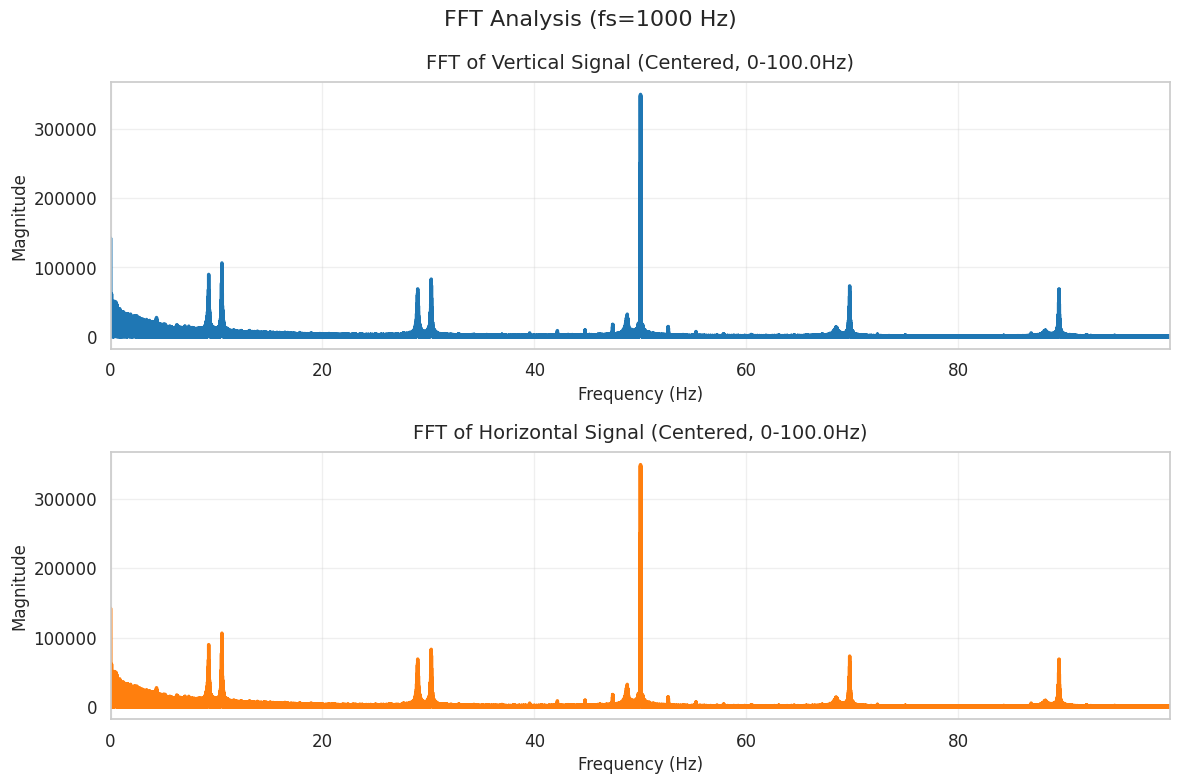

In [9]:
plot_fft_vertical_horizontal(raw_data['vertical_value'], raw_data['horizontal_value'], f)

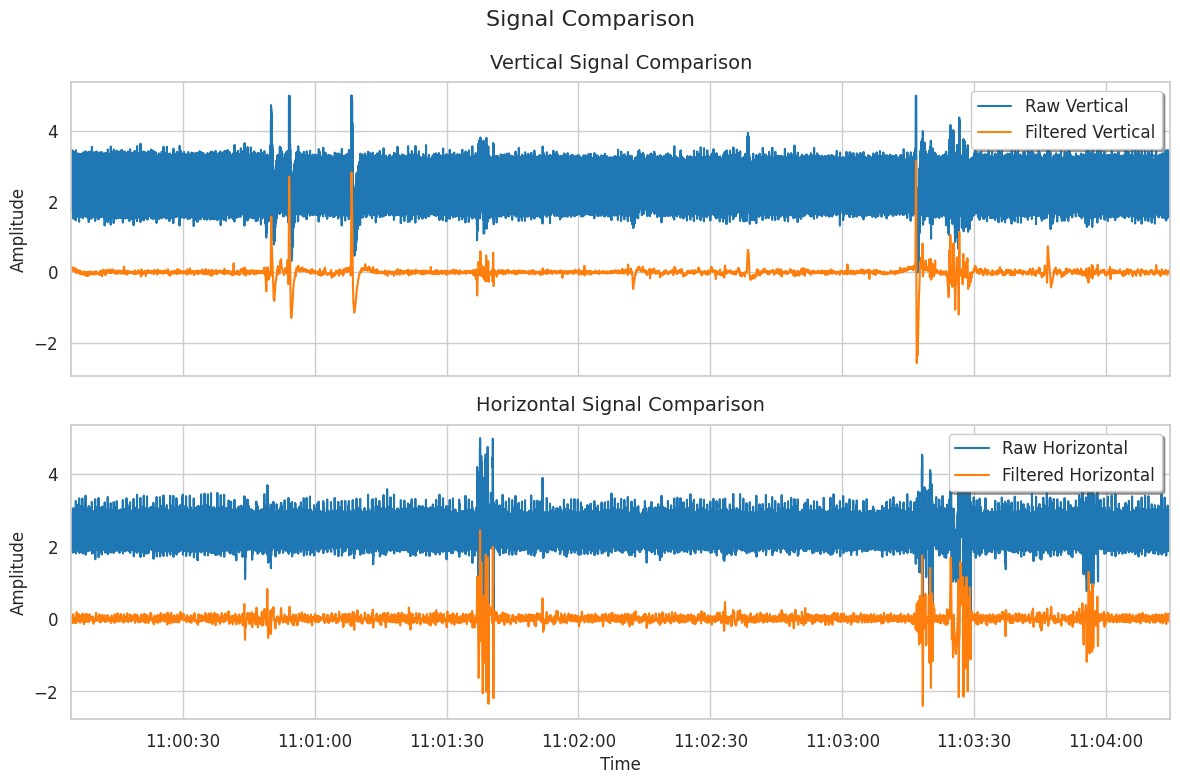

In [10]:
all_data = raw_data.resample("1ms").nearest().interpolate()
fs = 1 / pd.Series(all_data.index.diff().total_seconds()).median()
filter_order = 4

sos = signal.butter(filter_order, 30, btype="lowpass", analog=False, output='sos', fs=fs)

all_data['vertical_filtered'] = signal.sosfilt(sos, all_data['vertical_value'])
all_data['horizontal_filtered'] = signal.sosfilt(sos, all_data['horizontal_value'])

all_data = all_data.resample("5ms").mean()

lowcut_freq = 0.5
highcut_freq = 30
filter_order = 5

sos = signal.butter(filter_order, [lowcut_freq, highcut_freq], btype='band', analog=False, output='sos', fs=fs)

all_data['vertical_filtered'] = signal.sosfiltfilt(sos, all_data['vertical_value'])
all_data['horizontal_filtered'] = signal.sosfiltfilt(sos, all_data['horizontal_value'])


plot_signals_interactive(all_data[10000:], n_samples=50000)

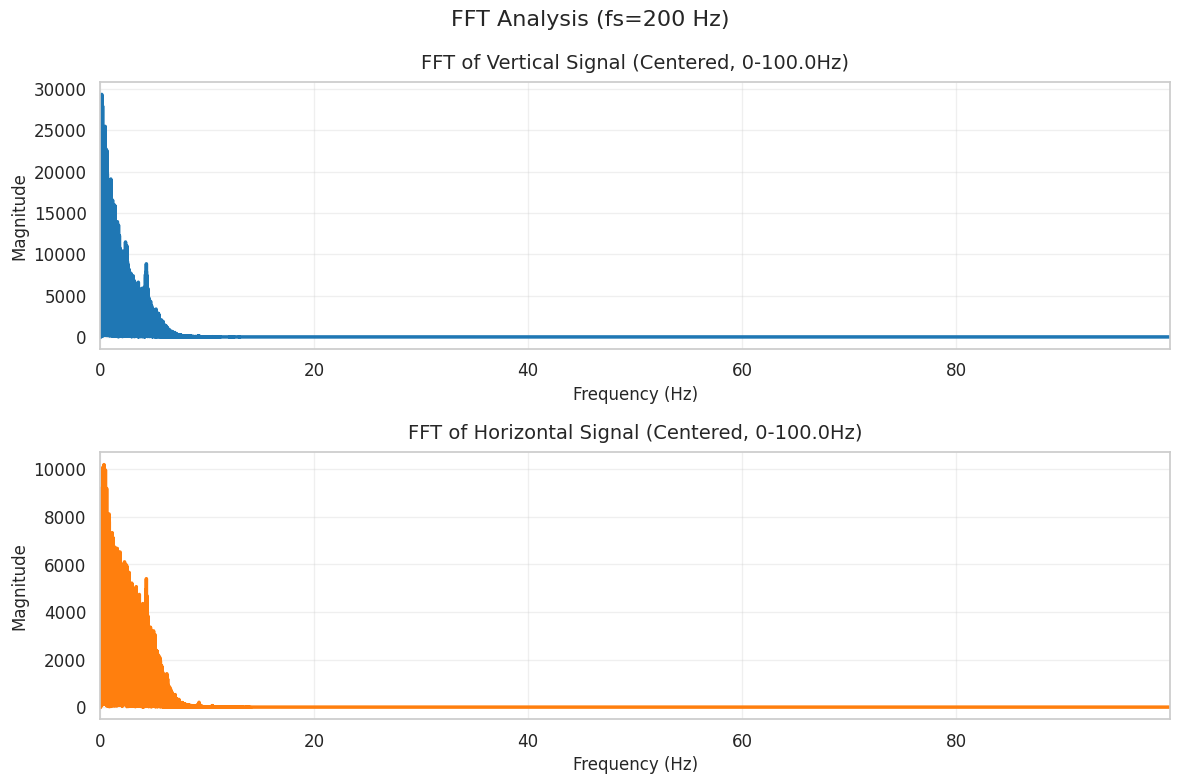

In [12]:
plot_fft_vertical_horizontal(all_data['horizontal_filtered'], all_data['vertical_filtered'], fs=200)

Import the Pavlovia data too

In [ ]:
data_sofia = pd.read_csv('/content/drive/MyDrive/Thesis/Code/Thesis/data/Sofia_Gonzalez_Mezquita_Data_Recording_Mental_Fatigue_Testing_Session_2025-03-27_14h03.19.382.csv')
data_nicolas = pd.read_csv('/content/drive/MyDrive/Thesis/Code/Thesis/data/Nicolas_Mental_Fatigue_Testing_Session_2025-03-27_10h59.40.458.csv')

id_sofia = 2
id_nicolas = 1

fs_sofia = 1000
fs_nicolas = 1000

In [ ]:
def extract_start_timestamp(filename: str) -> pd.Timestamp:
    # Extract the datetime part from the filename
    match = re.search(r'(\d{4}-\d{2}-\d{2})_(\d{2})h(\d{2})\.(\d{2})\.(\d{3})', filename)
    if not match:
        raise ValueError("Invalid filename format")

    date_part, hour, minute, second, millis = match.groups()
    timestamp_str = f"{date_part} {hour}:{minute}:{second}.{millis}"
    return pd.Timestamp(timestamp_str)

filename_sofia = "Sofia_Gonzalez_Mezquita_Data_Recording_Mental_Fatigue_Testing_Session_2025-03-27_14h03.19.382.csv"
filename_nicolas = "Nicolas_Mental_Fatigue_Testing_Session_2025-03-27_10h59.40.458.csv"
start_time_sofia = extract_start_timestamp(filename_sofia)
start_time_nicolas = extract_start_timestamp(filename_nicolas)

data_sofia['elapsed.time'] = pd.to_timedelta(data_sofia['elapsed.time'], unit='s')
data_sofia['timestamp'] = start_time_sofia + data_sofia['elapsed.time']
data_sofia['timestamp_str'] = data_sofia['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S.%f').str[:-3]

data_nicolas['elapsed.time'] = pd.to_timedelta(data_nicolas['elapsed.time'], unit='s')
data_nicolas['timestamp'] = start_time_nicolas + data_nicolas['elapsed.time']
data_nicolas['timestamp_str'] = data_nicolas['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S.%f').str[:-3]


In [ ]:
data_sofia.set_index("timestamp_str", inplace=True)
data_sofia.index.name = None

In [ ]:
data_sofia.index = pd.to_datetime(data_sofia.index)
data_sofia

,elapsed.time,key_resp.keys,key_resp.rt,F_ISA.duration,slider.response,slider.rt,slider1.response,slider1.rt,slider2.response,slider2.rt,...,mentRotTrialsLoop3.ran,break12.duration,key_resp_7.keys,key_resp_7.rt,AXCPTtrialsLoop3.thisRepN,AXCPTtrialsLoop3.thisTrialN,AXCPTtrialsLoop3.thisN,AXCPTtrialsLoop3.thisIndex,AXCPTtrialsLoop3.ran,timestamp
2025-03-27 14:05:06.040,0 days 00:01:46.658000,right,8.082,14.416,3.0,4.307,2.0,3.233,3.0,4.668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-27 14:05:06.040
2025-03-27 14:05:13.623,0 days 00:01:54.241000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-27 14:05:13.623
2025-03-27 14:05:20.790,0 days 00:02:01.408000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-27 14:05:20.790
2025-03-27 14:05:28.107,0 days 00:02:08.725000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-27 14:05:28.107
2025-03-27 14:05:35.657,0 days 00:02:16.275000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-27 14:05:35.657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27 16:44:51.519,0 days 02:41:32.137000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,0.0,80.0,1.0,1.0,2025-03-27 16:44:51.519
2025-03-27 16:44:58.750,0 days 02:41:39.368000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,1.0,81.0,5.0,1.0,2025-03-27 16:44:58.750
2025-03-27 16:45:05.800,0 days 02:41:46.418000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,2.0,82.0,2.0,1.0,2025-03-27 16:45:05.800
2025-03-27 16:45:14.001,0 days 02:41:54.619000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,3.0,83.0,9.0,1.0,2025-03-27 16:45:14.001


Combine both according to the timestamp

In [ ]:
combined_df = pd.concat([data_sofia, all_data]).sort_index()
combined_df.index.name = None

In [ ]:
combined_df

,elapsed.time,key_resp.keys,key_resp.rt,F_ISA.duration,slider.response,slider.rt,slider1.response,slider1.rt,slider2.response,slider2.rt,...,AXCPTtrialsLoop3.thisRepN,AXCPTtrialsLoop3.thisTrialN,AXCPTtrialsLoop3.thisN,AXCPTtrialsLoop3.thisIndex,AXCPTtrialsLoop3.ran,timestamp,vertical_value,horizontal_value,vertical_filtered,horizontal_filtered
2025-03-27 14:03:10.785,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.426686,2.382698,0.001606,-0.014790
2025-03-27 14:03:10.800,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.451124,2.407136,0.003011,-0.010629
2025-03-27 14:03:10.805,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.399804,2.399804,0.004405,-0.006514
2025-03-27 14:03:10.810,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.429130,2.434018,0.005770,-0.002483
2025-03-27 14:03:10.815,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.487781,2.438905,0.007087,0.001434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27 16:46:33.325,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.194526,2.473118,-0.423108,-0.076240
2025-03-27 16:46:33.330,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.463343,2.502444,-0.395219,-0.071442
2025-03-27 16:46:33.335,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.551320,2.492669,-0.366110,-0.066529
2025-03-27 16:46:33.350,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,2.534213,2.524438,-0.336218,-0.061551


Analysis

In [ ]:
slider_data = {}

descriptions = [
    "Panicky", "Lively", "Confused", "Worn out", "Depressed", "Downhearted", "Annoyed", "Exhausted", "Mixed-up",
    "Sleepy", "Bitter", "Unhappy", "Anxious", "Worried", "Energetic", "Miserable", "Muddled", "Nervous", "Angry",
    "Active", "Tired", "Bad tempered", "Alert", "Uncertain"
]

descriptions_EXTIMATED_GO_UP = [
    "Panicky", "Worn out", "Depressed", "Downhearted", "Annoyed", "Exhausted", "Mixed-up",
    "Sleepy", "Bitter", "Unhappy", "Anxious", "Worried", "Miserable", "Muddled", "Nervous", "Angry",
    "Tired", "Bad tempered", "Uncertain"
]

descriptions_EXTIMATED_GO_DOWN = [
    "Lively", "Energetic", "Active", "Confused", "Alert",
]

for X in range(0, 25):
    if X == 0:
        slider_column = 'slider.response'  # F-ISA
    else:
        slider_column = f'slider{X}.response'  # BRUMS Questionnaire

    filtered = combined_df[combined_df[slider_column].notna()]
    timestamps = filtered.index.strftime('%H:%M:%S.%f').tolist()
    slider_values = filtered[slider_column].tolist()
    description = descriptions[X-1]
    slider_data[slider_column] = {'timestamps': timestamps, 'slider_values': slider_values, 'description': description}

slider_data


{'slider.response': {'timestamps': ['14:05:06.040000',
   '14:15:36.174000',
   '14:27:17.775000',
   '14:54:41.296000',
   '15:05:09.444000',
   '15:17:22.979000',
   '15:29:23.213000',
   '15:47:59.798000',
   '15:58:18.581000',
   '16:12:15.899000',
   '16:24:58.599000',
   '16:35:07.533000',
   '16:46:23.136000'],
  'slider_values': [3.0,
   2.0,
   2.0,
   3.0,
   2.0,
   3.0,
   4.0,
   4.0,
   3.0,
   3.0,
   3.0,
   5.0,
   5.0],
  'description': 'Uncertain'},
 'slider1.response': {'timestamps': ['14:05:06.040000', '16:46:23.136000'],
  'slider_values': [2.0, 1.0],
  'description': 'Panicky'},
 'slider2.response': {'timestamps': ['14:05:06.040000', '16:46:23.136000'],
  'slider_values': [3.0, 1.0],
  'description': 'Lively'},
 'slider3.response': {'timestamps': ['14:05:06.040000', '16:46:23.136000'],
  'slider_values': [3.0, 1.0],
  'description': 'Confused'},
 'slider4.response': {'timestamps': ['14:05:06.040000', '16:46:23.136000'],
  'slider_values': [4.0, 5.0],
  'descripti

In [ ]:
columns_to_extract = [
    'slider.response', 'vertical_filtered', 'horizontal_filtered',
    'AXCPT_resp.rt', 'AXCPT_resp.corr',
    'NBack_resp_2.rt', 'NBack_resp_2.corr',
    'key_resp_14.rt', 'key_resp_14.corr',
    'MROT_resp.rt', 'MROT_resp.corr'
]

exploration_df = combined_df[columns_to_extract].copy()
exploration_df


,slider.response,vertical_filtered,horizontal_filtered,AXCPT_resp.rt,AXCPT_resp.corr,NBack_resp_2.rt,NBack_resp_2.corr,key_resp_14.rt,key_resp_14.corr,MROT_resp.rt,MROT_resp.corr
2025-03-27 14:03:10.785,NaN,0.001606,-0.014790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 14:03:10.800,NaN,0.003011,-0.010629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 14:03:10.805,NaN,0.004405,-0.006514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 14:03:10.810,NaN,0.005770,-0.002483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 14:03:10.815,NaN,0.007087,0.001434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27 16:46:33.325,NaN,-0.423108,-0.076240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 16:46:33.330,NaN,-0.395219,-0.071442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 16:46:33.335,NaN,-0.366110,-0.066529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 16:46:33.350,NaN,-0.336218,-0.061551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
combined_df.index = pd.to_datetime(combined_df.index)

end_time = combined_df.index.max()
start_time = end_time - pd.Timedelta(minutes=20)

filtered_df = combined_df[(combined_df.index >= start_time) & (combined_df.index <= end_time)]

exploration_df = filtered_df[columns_to_extract].copy()

fig = px.line(exploration_df, title="Last 30 minutes of Task Responses and Fatigue Measures",
              labels={col: col.replace('_', ' ').title() for col in exploration_df.columns},
              markers=True)

fig.show()

In [ ]:
exploration_df.head

,slider.response,vertical_filtered,horizontal_filtered,AXCPT_resp.rt,AXCPT_resp.corr,NBack_resp_2.rt,NBack_resp_2.corr,key_resp_14.rt,key_resp_14.corr,MROT_resp.rt,MROT_resp.corr
2025-03-27 14:03:10.785,NaN,0.001606,-0.014790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 14:03:10.800,NaN,0.003011,-0.010629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 14:03:10.805,NaN,0.004405,-0.006514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 14:03:10.810,NaN,0.005770,-0.002483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 14:03:10.815,NaN,0.007087,0.001434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27 16:46:33.325,NaN,-0.423108,-0.076240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 16:46:33.330,NaN,-0.395219,-0.071442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 16:46:33.335,NaN,-0.366110,-0.066529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-27 16:46:33.350,NaN,-0.336218,-0.061551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import nolds
import pywt
from EntropyHub import FuzzEn, SampEn, PermEn, DistEn
from scipy.signal import stft
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler

# ---------- Feature functions ----------

def compute_statistics(signal):
    return np.mean(signal), np.std(signal), stats.skew(signal), stats.kurtosis(signal)

def compute_fft_features(signal, fs=200):
    fft_vals = np.abs(fft(signal))
    return np.mean(fft_vals), np.std(fft_vals), np.max(fft_vals)

def compute_stft_features(signal, fs=200, window='hann', nperseg=256):
    _, _, Zxx = stft(signal, fs=fs, window=window, nperseg=nperseg)
    abs_Zxx = np.abs(Zxx)
    return np.mean(abs_Zxx), np.std(abs_Zxx)

def compute_wpt_features(signal, wavelet='db4', maxlevel=5):
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    coeffs = [node.data for node in wp.get_level(maxlevel, order='natural')]
    coeffs = np.concatenate(coeffs)
    return np.mean(coeffs), np.std(coeffs)

def compute_entropy_features(signal):
    fuzzy = FuzzEn(signal, m=2, tau=1, r=(0.2, 1))
    sample = SampEn(signal, m=2, tau=1, r=0.2)
    perm = PermEn(signal, m=3, tau=1)
    dist = DistEn(signal, m=2, tau=1)
    return fuzzy, sample, perm, dist

def compute_hurst_exponent(signal):
    return nolds.hurst_rs(signal)

# ---------- Sliding window logic ----------

from joblib import Parallel, delayed
from datetime import timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def process_window(start, end, signal, fs_estimate):
    if len(signal) < 2:
        return None

    # Standardize
    scaler = StandardScaler()
    signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()

    # Feature computations
    mean, std, skewness, kurtosis = compute_statistics(signal)
    fft_mean, fft_std, fft_max = compute_fft_features(signal, fs=fs_estimate)
    stft_mean, stft_std = compute_stft_features(signal, fs=fs_estimate)
    wpt_mean, wpt_std = compute_wpt_features(signal)
    fuzzy_entropy, sample_entropy, perm_entropy, dist_entropy = compute_entropy_features(signal)
    hurst = compute_hurst_exponent(signal)

    time_label = start + timedelta(seconds=(end - start).total_seconds() / 2)

    return [
        time_label,
        mean, std, skewness, kurtosis,
        fft_mean, fft_std, fft_max,
        stft_mean, stft_std,
        wpt_mean, wpt_std,
        fuzzy_entropy, sample_entropy, perm_entropy, dist_entropy,
        hurst
    ]

def extract_features_parallel(df, column_name, window_size_sec=2, overlap=0.5, n_jobs=-1):
    fs_estimate = 1 / df.index.to_series().diff().dt.total_seconds().median()
    print(f"Estimated sampling frequency: {fs_estimate:.2f} Hz")

    step_size = window_size_sec * (1 - overlap)
    start_time = df.index[0]
    end_time = df.index[-1]

    time_ranges = []
    current_start = start_time

    while current_start + timedelta(seconds=window_size_sec) <= end_time:
        current_end = current_start + timedelta(seconds=window_size_sec)
        window_series = df.loc[current_start:current_end][column_name].dropna().values
        time_ranges.append((current_start, current_end, window_series))
        current_start += timedelta(seconds=step_size)

    # Parallel processing
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(process_window)(start, end, signal, fs_estimate)
        for start, end, signal in time_ranges
    )

    results = [res for res in results if res is not None]

    if not results:
        return pd.DataFrame()

    timestamps, *features = zip(*results)
    feature_df = pd.DataFrame(features, columns=[
        'mean', 'std', 'skewness', 'kurtosis',
        'fft_mean', 'fft_std', 'fft_max',
        'stft_mean', 'stft_std',
        'wpt_mean', 'wpt_std',
        'fuzzy_entropy', 'sample_entropy', 'perm_entropy', 'dist_entropy',
        'hurst_exponent'
    ], index=timestamps)

    return feature_df

In [ ]:
feature_df = extract_features_parallel(exploration_df, 'vertical_filtered', window_size_sec=2, overlap=0.5, n_jobs=4)


Estimated sampling frequency: 200.00 Hz


ValueError: 16 columns passed, passed data had 9801 columns

In [ ]:
features_df = pd.DataFrame(features_over_time, columns=['v_fft_energy', 'v_stft_power', 'v_entropy',
                                                        'v_wt_energy', 'v_wpt_energy', 'h_fft_energy',
                                                        'h_stft_power', 'h_entropy', 'h_wt_energy',
                                                        'h_wpt_energy'])  # Modify column names as needed

# Assuming `slider_response` is the target variable you're interested in
features_df['slider_response'] = slider_response  # Add the target variable to the features dataframe

# Compute the correlation matrix
corr_matrix = features_df.corr()

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set plot title
plt.title('Correlation Matrix of Features and Slider Response', fontsize=16)
plt.show()


NameError: name 'slider_response' is not defined

In [ ]:
# Correlation between RT CORRECT and F-ISA (slider score wrt to features) - I want to learn which features are relvant
# fuzzy entropy, dispersion entropy, wavelet energy features, features on wavelet singularity and continuous wavalet transformation
# then train models such as SVM and GELM and KNN to predict F-ISA based on

Wavelet Packet Transform (WPT) performs a more fine-grained decomposition of the signal by recursively splitting both the approximation and detail coefficients. This makes it more sensitive to the high-frequency components of the signal, which can capture subtle variations (e.g., small eye movements or noise in the EOG signal).

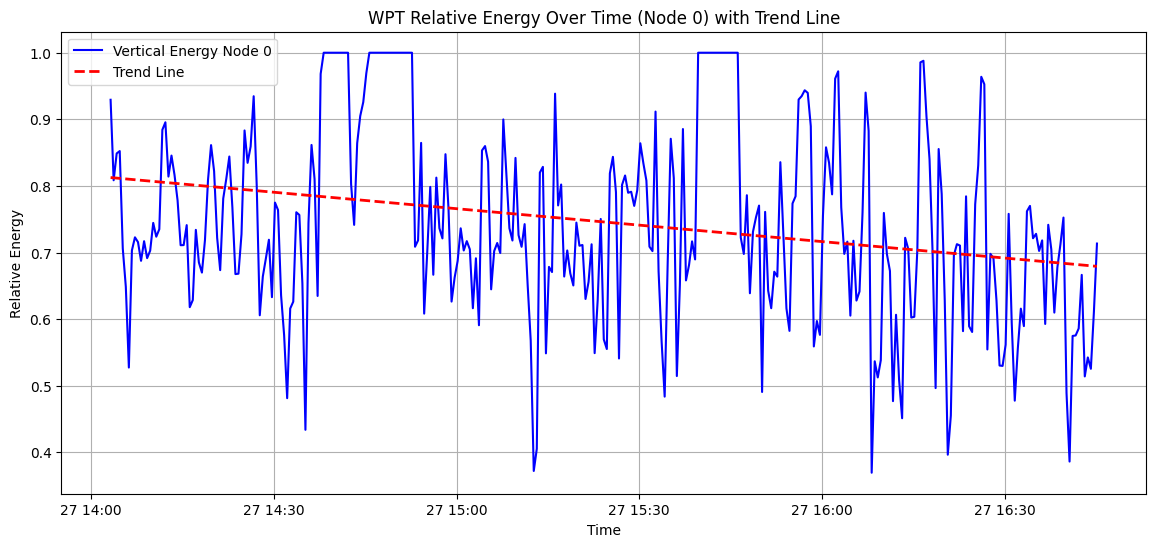

In [ ]:
vertical_signal = all_data['vertical_filtered']
horizontal_signal = all_data['horizontal_filtered']

window_size = pd.Timedelta(seconds=60)  # 60 seconds window
step_size = pd.Timedelta(seconds=30)    # 30 seconds step

def wpt_features(signal_data, wavelet='db4', maxlevel=5):
    wp = pywt.WaveletPacket(data=signal_data, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    nodes = wp.get_level(maxlevel, order='freq')

    energies = []
    entropies = []
    total_energy = sum(np.sum(np.square(node.data)) for node in nodes)

    for node in nodes:
        node_energy = np.sum(np.square(node.data))
        relative_energy = node_energy / total_energy if total_energy > 0 else 0
        energies.append(relative_energy)

        p_node = np.square(node.data)
        p_node = p_node / np.sum(p_node) if np.sum(p_node) != 0 else p_node
        node_entropy = -np.sum(p_node * np.log2(p_node + 1e-12))
        entropies.append(node_entropy)

    return np.array(energies), np.array(entropies)

# Sliding window feature extraction
start_time = all_data.index.min()
end_time = all_data.index.max()

current_start = start_time
features_over_time = []
timestamps = []

while current_start + window_size <= end_time:
    current_end = current_start + window_size
    v_window = vertical_signal[current_start:current_end].dropna()
    h_window = horizontal_signal[current_start:current_end].dropna()

    if len(v_window) > 0 and len(h_window) > 0:
        v_energy, v_entropy = wpt_features(v_window.values, wavelet='db3', maxlevel=5)
        h_energy, h_entropy = wpt_features(h_window.values, wavelet='db3', maxlevel=5)
        feature_vector = np.concatenate([v_energy, v_entropy, h_energy, h_entropy])
        features_over_time.append(feature_vector)
        timestamps.append(current_start)

    current_start += step_size

features_over_time = np.array(features_over_time)
timestamps = pd.to_datetime(timestamps)

#trendline
feature_index = 0
feature_values = features_over_time[:, feature_index]
timestamps_numeric = (timestamps - timestamps[0]).total_seconds()

#linear trend line
slope, intercept, r_value, p_value, std_err = stats.linregress(timestamps_numeric, feature_values)
trendline = slope * timestamps_numeric + intercept

plt.figure(figsize=(14,6))
plt.plot(timestamps, feature_values, label="Vertical Energy Node 0", color="blue")
plt.plot(timestamps, trendline, label="Trend Line", color="red", linestyle="--", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Relative Energy")
plt.title("WPT Relative Energy Over Time (Node 0) with Trend Line")
plt.legend()
plt.grid()
plt.show()

![image.png](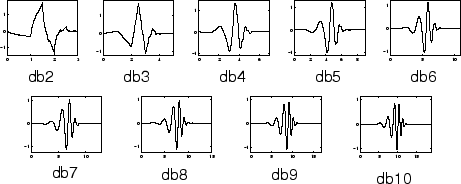
)

If the relative energy at a certain wavelet node is decreasing over time:

It suggests that the signal power in that specific frequency band is dropping.

In EOG, certain frequency bands (especially low frequencies, like slow eye movements or micro-saccades) are sensitive to alertness and fatigue.

A decrease in relative energy can reflect reduced eye movement dynamics, lower blink rate, or more sluggish and fewer eye movements. -----eye activity is becoming less energetic

**Shannon entropy** is a measure of the uncertainty or unpredictability in a signal. In the case of EOG data, it reflects how much information is contained in the vertical eye movements.

Higher entropy means that the signal is more variable and unpredictable, while lower entropy indicates that the signal is more regular and repetitive.

In [ ]:
import pywt
import numpy as np
import pandas as pd
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import entropy as scipy_entropy
import matplotlib.pyplot as plt

def compute_fft_features(signal_data, fs):
    fft_vals = np.abs(fft(signal_data))
    fft_freqs = np.fft.fftfreq(len(signal_data), d=1/fs)
    positive_freqs = fft_vals[fft_freqs >= 0]
    energy = np.sum(positive_freqs**2)
    return energy

def compute_stft_features(signal_data, fs):
    f, t, Zxx = stft(signal_data, fs=fs, nperseg=256)
    power = np.abs(Zxx)**2
    avg_power = np.mean(power)
    return avg_power

def compute_wt_features(signal_data, wavelet='db4', level=5):
    coeffs = pywt.wavedec(signal_data, wavelet, level=level)
    energies = [np.sum(c**2) for c in coeffs]
    total_energy = sum(energies)
    relative_energies = [e/total_energy for e in energies] if total_energy > 0 else np.zeros(len(energies))
    return np.array(relative_energies)

def compute_wpt_features(signal_data, wavelet='db4', maxlevel=5):
    wp = pywt.WaveletPacket(data=signal_data, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    nodes = wp.get_level(maxlevel, order='freq')
    energies = []
    total_energy = sum(np.sum(np.square(node.data)) for node in nodes)
    for node in nodes:
        node_energy = np.sum(np.square(node.data))
        relative_energy = node_energy / total_energy if total_energy > 0 else 0
        energies.append(relative_energy)
    return np.array(energies)

def compute_shannon_entropy(signal_data):
    hist, bin_edges = np.histogram(signal_data, bins=100, density=True)
    hist = hist + 1e-12  # Avoid log(0)
    shannon_entropy = scipy_entropy(hist, base=2)
    return shannon_entropy

def extract_features_from_signal(vertical_signal, horizontal_signal, window_size, step_size, fs):
    start_time = vertical_signal.index.min()
    end_time = vertical_signal.index.max()

    current_start = start_time
    features_over_time = []
    timestamps = []

    while current_start + window_size <= end_time:
        current_end = current_start + window_size
        v_window = vertical_signal[current_start:current_end].dropna()
        h_window = horizontal_signal[current_start:current_end].dropna()

        if len(v_window) > 0 and len(h_window) > 0:
            # Vertical features
            v_fft_energy = compute_fft_features(v_window.values, fs)
            v_stft_power = compute_stft_features(v_window.values, fs)
            v_wt_energy = compute_wt_features(v_window.values, wavelet='db4', level=5)
            v_wpt_energy = compute_wpt_features(v_window.values, wavelet='db4', maxlevel=5)
            v_entropy = compute_shannon_entropy(v_window.values)

            # Horizontal features
            h_fft_energy = compute_fft_features(h_window.values, fs)
            h_stft_power = compute_stft_features(h_window.values, fs)
            h_wt_energy = compute_wt_features(h_window.values, wavelet='db4', level=5)
            h_wpt_energy = compute_wpt_features(h_window.values, wavelet='db4', maxlevel=5)
            h_entropy = compute_shannon_entropy(h_window.values)

            feature_vector = np.concatenate([
                [v_fft_energy, v_stft_power, v_entropy],
                v_wt_energy,
                v_wpt_energy,
                [h_fft_energy, h_stft_power, h_entropy],
                h_wt_energy,
                h_wpt_energy
            ])

            features_over_time.append(feature_vector)
            timestamps.append(current_start)

        current_start += step_size

    # Convert list of features to a DataFrame
    features_over_time = np.array(features_over_time)
    timestamps = pd.to_datetime(timestamps)

    # Update column names to match the number of features
    columns = [
        'v_fft_energy', 'v_stft_power', 'v_entropy',
        'v_wt_energy_1', 'v_wt_energy_2', 'v_wt_energy_3', 'v_wt_energy_4',
        'v_wpt_energy_1', 'v_wpt_energy_2', 'v_wpt_energy_3',
        'h_fft_energy', 'h_stft_power', 'h_entropy',
        'h_wt_energy_1', 'h_wt_energy_2', 'h_wt_energy_3', 'h_wt_energy_4',
        'h_wpt_energy_1', 'h_wpt_energy_2', 'h_wpt_energy_3'
    ]

    features_df = pd.DataFrame(features_over_time, columns=columns)  # Ensure the number of columns matches
    features_df['timestamp'] = timestamps

    return features_df

To normalize the data between differrent users we can usse log scale, here is how to plot it

In [ ]:
plot_signals_interactive(np.log10(10*all_data + 2.5), n_samples=50000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
safe_data = 10 * all_data + 2.5
safe_data_clipped = np.clip(safe_data, a_min=1e-6, a_max=None)
log_all_data = np.log10(safe_data_clipped)

Analysis


In [ ]:
window_size_sec = 10
step_size_sec = 5
fs = 1 / pd.Series(log_all_data.index.to_series().diff().dt.total_seconds()).median()
fs = float(fs)

window_size_samples = int(window_size_sec * fs)
step_size_samples = int(step_size_sec * fs)


In [ ]:
def band_power(f, Pxx, fmin, fmax):
    mask = (f >= fmin) & (f <= fmax)
    return np.trapz(Pxx[mask], f[mask])

def compute_features(segment_v, segment_h, fs):
    # Power Spectral Density (PSD)
    f_v, Pxx_v = welch(segment_v, fs=fs, nperseg=len(segment_v)//2)
    f_h, Pxx_h = welch(segment_h, fs=fs, nperseg=len(segment_h)//2)

    features = {}

    for axis, f, Pxx, seg in zip(['v', 'h'], [f_v, f_h], [Pxx_v, Pxx_h], [segment_v, segment_h]):

        # Frequency domain power features
        features[f'low_power_{axis}'] = band_power(f, Pxx, 0.5, 4)
        features[f'mid_power_{axis}'] = band_power(f, Pxx, 4, 10)

        # Time domain statistical features
        features[f'mean_{axis}'] = np.mean(seg)
        features[f'var_{axis}'] = np.var(seg)
        features[f'skew_{axis}'] = skew(seg)
        features[f'kurtosis_{axis}'] = kurtosis(seg)
        features[f'entropy_{axis}'] = entropy(np.histogram(seg, bins=30, density=True)[0] + 1e-6)

        # Additional time domain features
        features[f'peak_to_peak_{axis}'] = np.ptp(seg)  # Peak-to-Peak Amplitude
        features[f'rms_{axis}'] = np.sqrt(np.mean(seg**2))  # Root Mean Square (RMS)
        features[f'zcr_{axis}'] = ((seg[:-1] * seg[1:]) < 0).sum()  # Zero Crossing Rate (ZCR)

        # Autocorrelation: Measures the similarity between a signal and a lagged version of itself
        features[f'autocorr_{axis}'] = np.corrcoef(seg[:-1], seg[1:])[0, 1]

        # Envelope using Hilbert Transform (Amplitude envelope)
        analytic_signal = hilbert(seg)
        envelope = np.abs(analytic_signal)
        features[f'envelope_{axis}'] = np.mean(envelope)

        # Frequency domain features
        spectral_centroid = np.sum(f * Pxx) / np.sum(Pxx)  # Spectral Centroid
        features[f'spectral_centroid_{axis}'] = spectral_centroid

        spectral_spread = np.sqrt(np.sum((f - spectral_centroid)**2 * Pxx) / np.sum(Pxx))  # Spectral Spread
        features[f'spectral_spread_{axis}'] = spectral_spread

        spectral_flux = np.sum(np.diff(Pxx)**2)  # Spectral Flux
        features[f'spectral_flux_{axis}'] = spectral_flux

        # Spectral Roll-off: Frequency below which a certain percentage of total spectral energy lies (85%)
        rolloff = np.argmax(np.cumsum(Pxx) >= 0.85 * np.sum(Pxx)) * f[1]
        features[f'spectral_rolloff_{axis}'] = rolloff

    return features


In [ ]:
vertical = log_all_data['vertical_filtered'].values
horizontal = log_all_data['horizontal_filtered'].values
print(vertical)
features = []

for start in range(0, len(vertical) - window_size_samples, step_size_samples):
    end = start + window_size_samples
    segment_v = vertical[start:end]
    segment_h = horizontal[start:end]

    feature_dict = compute_features(segment_v, segment_h, fs)
    features.append(feature_dict)


[ 0.40072068  0.40313916  0.40552602 ... -6.         -6.
 -6.        ]


<ipython-input-13-c748fd5e3fcd>:8: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning:

invalid value encountered in divide

<ipython-input-13-c748fd5e3fcd>:27: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

<ipython-input-13-c748fd5e3fcd>:28: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide



In [ ]:
features_df = pd.DataFrame(features)
features_df['time_sec'] = np.arange(len(features_df)) * step_size_sec

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

features_df = pd.DataFrame(features)
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_df)
normalized_features_df = pd.DataFrame(normalized_features, columns=features_df.columns)
normalized_features_df['time_sec'] = np.arange(len(normalized_features_df)) * step_size_sec


In [ ]:
moothed_features = normalized_features_df.rolling(window=10).mean()
plt.figure(figsize=(10, 6))
melted = smoothed_features.melt(id_vars='time_sec',
                          value_vars=[
                              'low_power_v', 'mid_power_v', 'mean_v', 'var_v', 'skew_v', 'kurtosis_v', 'entropy_v',
                              'peak_to_peak_v', 'rms_v', 'zcr_v', 'autocorr_v', 'envelope_v', 'spectral_centroid_v',
                              'spectral_spread_v', 'spectral_flux_v', 'spectral_rolloff_v',

                              'low_power_h', 'mid_power_h', 'mean_h', 'var_h', 'skew_h', 'kurtosis_h', 'entropy_h',
                              'peak_to_peak_h', 'rms_h', 'zcr_h', 'autocorr_h', 'envelope_h', 'spectral_centroid_h',
                              'spectral_spread_h', 'spectral_flux_h', 'spectral_rolloff_h'
                          ],
                          var_name='feature', value_name='value')

melted['channel'] = melted['feature'].str.extract(r'_(v|h)$').replace({'v': 'Vertical', 'h': 'Horizontal'})
fig = px.line(melted, x='time_sec', y='value', color='feature', facet_col='channel',
              title='Signal Features Over Time by Channel', height=800)
fig.update_layout(
    legend_title_text='Feature',
    title_x=0.5,
    showlegend=True
)
fig.show()

<Figure size 1000x600 with 0 Axes>

In [ ]:
# TODO: Exploration on the data- till block 2 (before recording more data)

 Spectral spead and roll off

Skewness - negative as fatigue increases

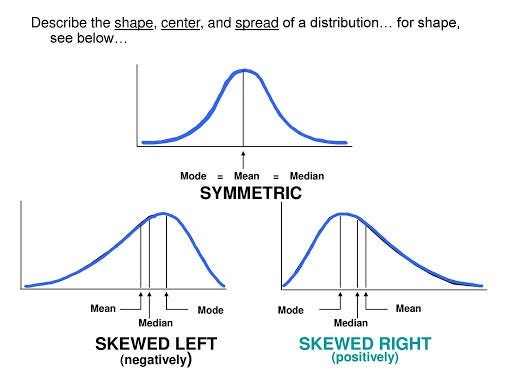

Kurtosis - increase whn fatigue was higher

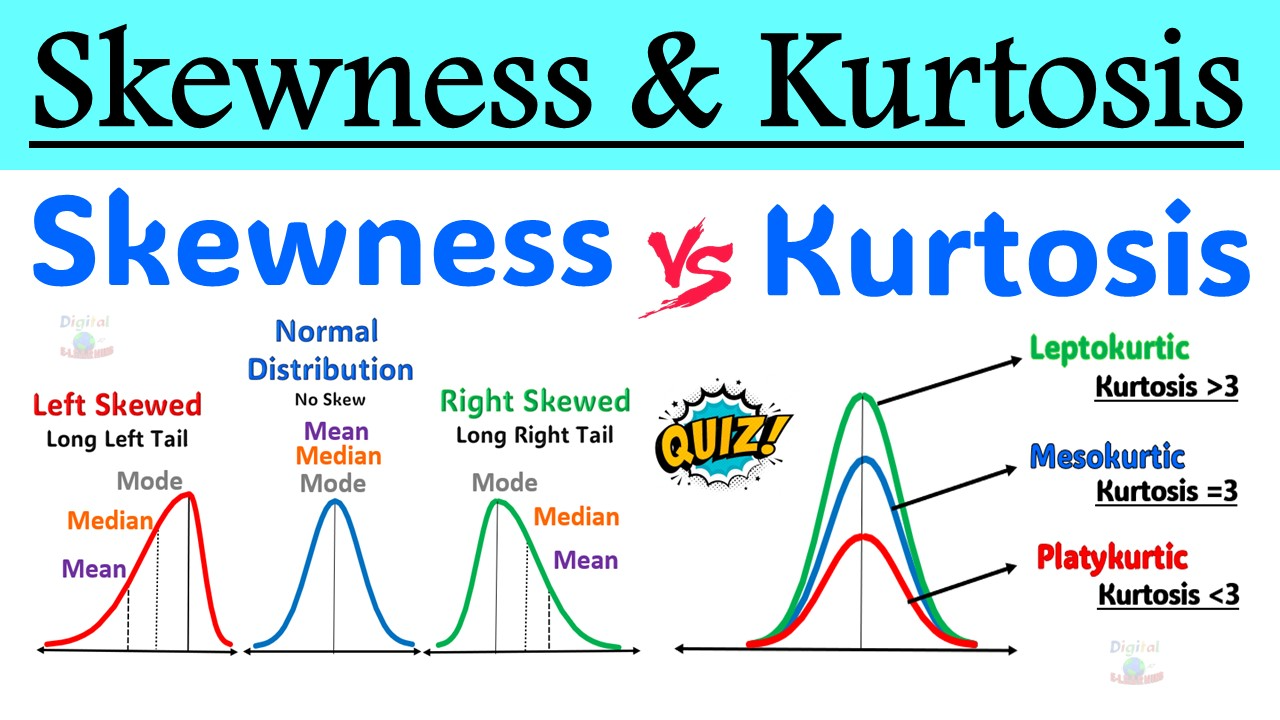



# Exploration of the real Sampling rate

# Filtering the signal

In [ ]:
clipped_points_v = all_data[
    (all_data['vertical_filtered'] <= 0.01) | (all_data['vertical_filtered'] >= 4.99)
]
clipped_points_h = all_data[
    (all_data['horizontal_filtered'] <= 0.01) | (all_data['horizontal_filtered'] >= 4.99)
]

print("Clipped points vertical:", len(clipped_points_v))
print("Clipped points horizontal:", len(clipped_points_h))


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=all_data.index[:100000000], y=all_data['vertical_filtered'].iloc[:100000000],
                         mode='lines', name='Vertical Filtered'))

fig.add_trace(go.Scatter(x=clipped_points_v_subset.index,
                         y=clipped_points_v_subset['vertical_filtered'],
                         mode='markers', name='Clipped Points', marker=dict(color='red', size=5)))

fig.update_layout(title="Clipping Detection - Vertical Signal",
                  xaxis_title="Time",
                  yaxis_title="Vertical Signal",
                  template="plotly_dark")
fig.show()


In [ ]:
all_data['vertical_filtered'] = all_data['vertical_filtered'].clip(0, 5)
all_data['horizontal_filtered'] = all_data['horizontal_filtered'].clip(0, 5)


In [ ]:
vertical_original = all_data['vertical_smoothed'].values[:1000]
horizontal_original = all_data['horizontal_smoothed'].values[:1000]
vertical_downsampled_1000 = vertical_downsampled[:1000]
horizontal_downsampled_1000 = horizontal_downsampled[:1000]

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(vertical_original, label='Original Vertical Signal', color='blue')
plt.plot(vertical_downsampled_1000, label='Downsampled Vertical Signal (256Hz)', color='red', linestyle='--')
plt.title('Vertical EOG Signal: Original vs Downsampled')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(horizontal_original, label='Original Horizontal Signal', color='blue')
plt.plot(horizontal_downsampled_1000, label='Downsampled Horizontal Signal (256Hz)', color='red', linestyle='--')
plt.title('Horizontal EOG Signal: Original vs Downsampled')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

# Signal Exploration

In [ ]:
all_data.columns

Index(['timestamp', 'vertical_value', 'horizontal_value', 'vertical_filtered',
       'horizontal_filtered', 'vertical_smoothed', 'horizontal_smoothed',
       'vertical_baseline'],
      dtype='object')

In [ ]:
os.chdir('blink_detection_model')

In [ ]:
files_in_blink = [f for f in os.listdir('.') if os.path.isfile(f)]
print("Files in the 'blink_detection_model' folder:", files_in_blink)

Files in the 'blink_detection_model' folder: ['rf_model_trained.pkl', 'Matlab_pipeline .ipynb', '.DS_Store', 'best_knn_model_trained.pkl', 'DataDescription.pdf', 'lstm_model_trained.pkl', 'gb_model_trained.pkl', 'best_knn_model_checkpoint.pkl', 'gb_model_checkpoint.pkl', 'rf_model_checkpoint.pkl']


In [ ]:
loaded_models = {}

for filename in os.listdir('.'):
    if filename.endswith('trained.pkl'):
        var_name = re.sub(r'\W|^(?=\d)', '_', os.path.splitext(filename)[0])
        with open(filename, 'rb') as f:
            model = pickle.load(f)
            loaded_models[var_name] = model
            globals()[var_name] = model


In [ ]:
for name, model in loaded_models.items():
    print(f"{name}: {type(model)}")


rf_model_trained: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
best_knn_model_trained: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
lstm_model_trained: <class 'keras.src.engine.sequential.Sequential'>
gb_model_trained: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


In [ ]:
# Select first 1000 samples of the smoothed EOG signal
vertical = all_data['vertical_smoothed'].values[:1000]
horizontal = all_data['horizontal_smoothed'].values[:1000]


# Use your existing feature extractor
X_pred = extract_features_for_prediction(
    eog_horizontal=horizontal,
    eog_vertical=vertical
)


# Predict blink behavior
y_pred = rf_model_trained.predict(X_pred)

# Output
print("Predicted label(s):", y_pred)


Predicted label(s): ['1' '1' '1' '3' '1' '3' '3' '3' '1' '3' '1' '3' '3' '1' '1' '1']


/Users/stepankrivosheev/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



/Users/stepankrivosheev/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/stepankrivosheev/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/stepankrivosheev/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/stepankrivosheev/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/stepankrivosheev/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/stepankrivosheev/anaconda3/l

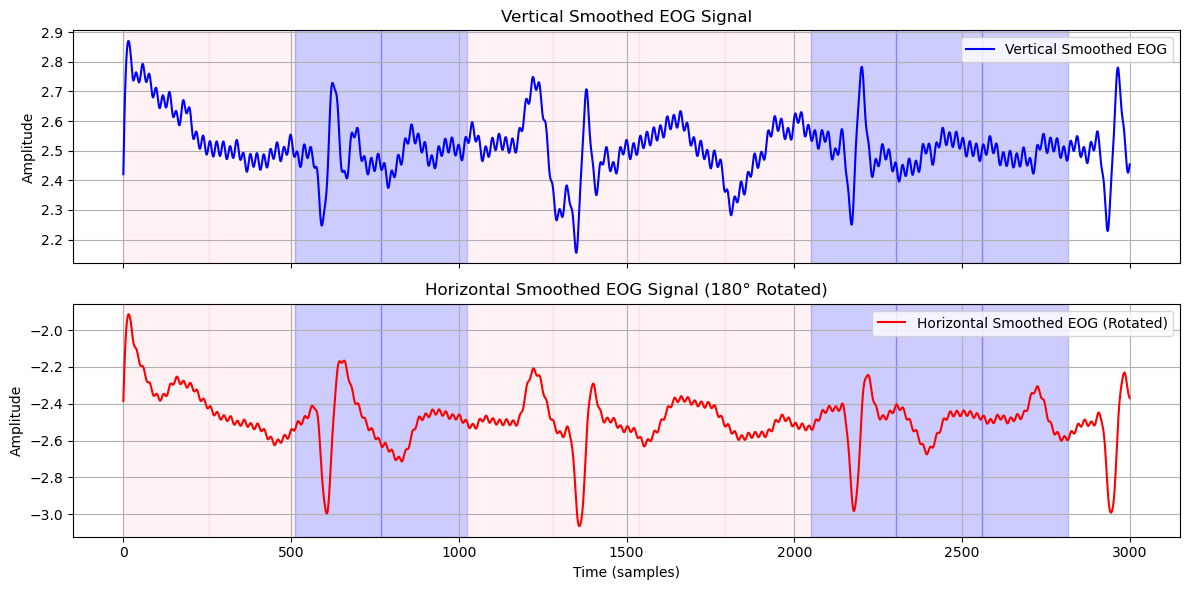

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select first 3000 samples
vertical = all_data['vertical_smoothed'].values[:3000]
horizontal = all_data['horizontal_smoothed'].values[:3000]

# Rotate horizontal by 180 degrees (flip vertically)
horizontal = -horizontal
F
# Create a time array
time = range(3000)

# Sliding window for predictions
window_size = 256
predictions = []

for start_idx in range(0, len(vertical) - window_size + 1, window_size):
    end_idx = start_idx + window_size
    vertical_window = vertical[start_idx:end_idx]
    horizontal_window = horizontal[start_idx:end_idx]

    X_pred = extract_features_for_prediction(eog_horizontal=horizontal_window, eog_vertical=vertical_window)

    if X_pred.ndim == 1:
        if X_pred.shape[0] == 0: continue
        X_pred = X_pred.reshape(1, -1)
    elif X_pred.ndim == 2:
        if X_pred.shape[1] == 0: continue
    else:
        continue

    y_pred = rf_model_trained.predict(X_pred)

    predictions.append({
        'prediction': int(y_pred[0]),  # convert to int for easier checking
        'time_range': (start_idx, end_idx)
    })

# Create the plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot vertical EOG signal
axes[0].plot(time, vertical, label='Vertical Smoothed EOG', color='blue')
axes[0].set_title('Vertical Smoothed EOG Signal')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True)
axes[0].legend()

# Plot horizontal EOG signal
axes[1].plot(time, horizontal, label='Horizontal Smoothed EOG (Rotated)', color='red')
axes[1].set_title('Horizontal Smoothed EOG Signal (180° Rotated)')
axes[1].set_xlabel('Time (samples)')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True)
axes[1].legend()

# Add prediction blocks
for pred in predictions:
    start, end = pred['time_range']
    if pred['prediction'] == 1:
        for ax in axes:
            ax.axvspan(start, end, color='blue', alpha=0.2)
    elif pred['prediction'] == 3:
        for ax in axes:
            ax.axvspan(start, end, color='pink', alpha=0.2)

plt.tight_layout()
plt.show()


In [ ]:
horizontal = all_data['horizontal_smoothed'].values
vertical = all_data['vertical_smoothed'].values

In [ ]:
X_pred = extract_features_for_prediction(horizontal, vertical)
y_pred = rf_model_trained.predict(X_pred)


In [ ]:
blink_indices = np.where(y_pred == 3)[0]
print(f"Blink detected in windows: {blink_indices}")
